In [2]:
from scene import Scene
import taichi as ti
from taichi.math import *
import taichi.math as tm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import ndimage
import trimesh
import open3d as o3d

import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

%load_ext autoreload
%autoreload 2

matplotlib.use('Qt5Agg')
%matplotlib widget

[Taichi] version 1.7.1, llvm 15.0.1, commit 0f143b2f, win, python 3.11.9
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## 1. Load model as voxel (e.g. Stanford bunny)

In [23]:
NUM_X, NUM_Y, NUM_Z = 128, 128, 128
GLASS_IOR = 1.5

def load_and_voxelize_mesh(file_path: str, voxel_size=0.005, num_x=NUM_X, num_y=NUM_Y, num_z=NUM_Z, need_rotate=False) -> np.ndarray:
    target_mesh = trimesh.load(file_path)
    assert isinstance(target_mesh, trimesh.Trimesh), "Loaded object should be a Trimesh"
    vertices = target_mesh.vertices
    faces = target_mesh.faces

    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.compute_vertex_normals()

    voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size)

    filled_voxels = np.zeros((num_x, num_y, num_z), dtype=np.uint8)
    for voxel in voxel_grid.get_voxels():
        voxel_coord = voxel.grid_index
        filled_voxels[voxel_coord[0], voxel_coord[1], voxel_coord[2]] = True
    for y in range(filled_voxels.shape[1]):
        slice_y = filled_voxels[:, y, :]
        filled_slice = ndimage.binary_fill_holes(slice_y)
        filled_voxels[:, y, :] = filled_slice

    if need_rotate:
        filled_voxels = np.transpose(filled_voxels, (0, 2, 1))  # 将y轴和z轴交换
        filled_voxels = np.flip(filled_voxels, axis=2)  # 沿新的y轴（原来的z轴）上下翻转

    print("Voxel shape:", filled_voxels.shape)  
    print("Number of filled voxels:", np.sum(filled_voxels))
    return filled_voxels


file_path = './assets/bun_zipper_res4.ply'
voxel_size = 0.004
bunny_voxels = load_and_voxelize_mesh(file_path, voxel_size)

file_path = "./assets/wine_glass.obj"
voxel_size = 0.09
glass_voxels = load_and_voxelize_mesh(file_path, voxel_size, need_rotate=True)

Voxel shape: (128, 128, 128)
Number of filled voxels: 13849
Voxel shape: (128, 128, 128)
Number of filled voxels: 5258


## 2. Preview scene using Path Tracing

In [24]:
@ti.func
def add_ball(r: ti.i32, origin: tm.vec3, color: tm.vec3, mat: ti.i8):
    pad = 1
    for i, j, k in ti.ndrange((-r-pad, r+pad), (-r-pad, r+pad), (-r-pad, r+pad)):
        xyz = ivec3(i, j, k)
        if xyz.dot(xyz) < r**2: 
            scene.set_voxel(vec3(i, j, k) + origin, mat, color, ior=GLASS_IOR)

@ti.func 
def add_bunny(origin: tm.vec3, color: tm.vec3, mat: ti.i8):
    for i, j, k in ti.ndrange(NUM_X, NUM_Y, NUM_Z):
        if bunny_field[i, j, k] == 1:
            scene.set_voxel(vec3(i, j, k) + origin, mat, color, ior=GLASS_IOR)

@ti.func
def add_glass(origin: tm.vec3, color: tm.vec3, mat: ti.i8):
    for i, j, k in ti.ndrange(NUM_X, NUM_Y, NUM_Z):
        if glass_field[i, j, k] == 1:
            scene.set_voxel(vec3(i, j, k) + origin, mat, color, ior=GLASS_IOR)

@ti.func
def origin_y(largest: int, r: int):
    return -(largest-r)-1

# Material LAMBERTIAN = 1
# Material LIGHT = 2
@ti.kernel
def initialize_voxels():
    # add_ball(LARGE_R, vec3(-18, origin_y(LARGE_R, LARGE_R), 0), RED, 1)
    # add_ball(MEDIUM_R, vec3(2, origin_y(LARGE_R, MEDIUM_R), 30), BLUE, 1)
    # add_ball(SMALL_R, vec3(47, -18, 37), WHITE, 1)
    # add_bunny(vec3(3, -18, -6), WHITE, 1)
    add_glass(vec3(3, -18, 3), WHITE, 1)
    
def floor_h(largest: int):
    return -1 / 64 * (largest)  #  could +1 to make balls float a bit above the floor

LARGE_R, MEDIUM_R, SMALL_R = 18, 12, 6

BLACK, WHITE, YELLOW, PINK = vec3(0, 0, 0), vec3(1, 1, 1), vec3(1,1,0), vec3(1,0.5,0.8)
RED, BLUE, PURPLE, AZURE = vec3(0.9, 0, 0.1), vec3(0, 0.5, 1), vec3(0.2, 0.2, 0.6), vec3(0.4, 0.7, 1)

torch.cuda.empty_cache()
scene = Scene(exposure=1)

bunny_field = ti.field(dtype=ti.u8, shape=(NUM_X, NUM_Y, NUM_Z))
bunny_field.from_numpy(bunny_voxels)

glass_field = ti.field(dtype=ti.u8, shape=(NUM_X, NUM_Y, NUM_Z))
glass_field.from_numpy(glass_voxels)

scene.set_directional_light((0, 1, 0), 0.2, (1, 1, 1))
scene.set_background_color((1, 1, 1))

FLOOR_HEIGHT = floor_h(LARGE_R)
print("Floor height:", FLOOR_HEIGHT)
scene.set_floor(height=FLOOR_HEIGHT, color=AZURE)
initialize_voxels()
scene.finish()

[Taichi] Starting on arch=cuda

Camera:
* Drag with your left mouse button to rotate
* Press W/A/S/D/Q/E to move

Floor height: -0.28125


In [23]:
(1 + FLOOR_HEIGHT) * NUM_Y / 2

46.0

## 3. View scene's IOR

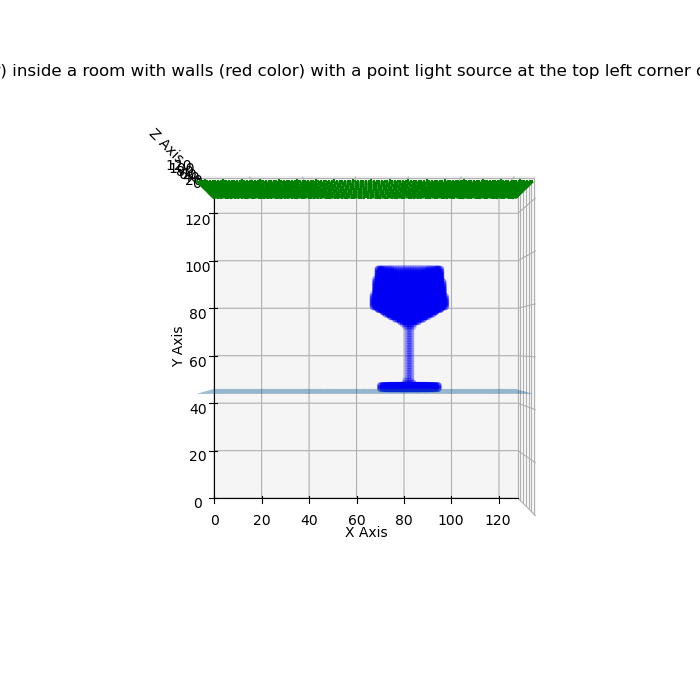

In [25]:
scene_ior = scene.get_ior_grid().to_torch().to(device)
assert isinstance(scene_ior, torch.Tensor) and scene_ior.shape == (NUM_X, NUM_Y, NUM_Z), "The scene IOR should be a torch tensor of shape (NUM_X, NUM_Y, NUM_Z)"
initial_wavefront_pos = torch.tensor([(x, NUM_Y-1, z) for x in range(NUM_X) for z in range(NUM_Z)], device=device)
initial_wavefront_dir = torch.tensor([(0, -1, 0) for _ in range(NUM_X * NUM_Z)], device=device)


def plot_floor() -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    xx, zz = np.meshgrid(np.arange(NUM_X), np.arange(NUM_Z))
    yy = np.ones_like(xx) * (1+FLOOR_HEIGHT) * NUM_Y/2
    return xx, yy, zz


def show_ior_field(ior_field: torch.Tensor, initial_wavefront_positions: torch.Tensor, initial_wavefront_directions: torch.Tensor):    
    plt.close("all") # clear previous plot

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1,1,1])
    ax.set_xlim(0, NUM_X)
    ax.set_ylim(0, NUM_Y)
    ax.set_zlim(0, NUM_Z)
    initial_pos_np = initial_wavefront_positions.cpu().numpy()
    initial_dir_np = initial_wavefront_directions.cpu().numpy()

    # Initial wavefront positions
    subsample_indices = np.arange(0, len(initial_pos_np), 7)
    ax.quiver(initial_pos_np[subsample_indices, 0], initial_pos_np[subsample_indices, 1], initial_pos_np[subsample_indices, 2],
                initial_dir_np[subsample_indices, 0], initial_dir_np[subsample_indices, 1], initial_dir_np[subsample_indices, 2],
                color='green', length=1)
    

    # Regular sampling for the sphere
    x_points_sphere, y_points_sphere, z_points_sphere = torch.where(ior_field.cpu() == GLASS_IOR)
    subsample_step_sphere = max(1, len(x_points_sphere) // 4000)  # Adjust the number to control the number of points
    subsample_indices_sphere = np.arange(0, len(x_points_sphere), subsample_step_sphere)
    ax.scatter(x_points_sphere[subsample_indices_sphere], y_points_sphere[subsample_indices_sphere], z_points_sphere[subsample_indices_sphere], color='blue', alpha=0.08)
    ax.set_title("Glass Sphere (blue color) inside a room with walls (red color) with a point light source at the top left corner of the room (green arrows)")
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.view_init(elev=90, azim=-90)

    xx, yy, zz = plot_floor()
    ax.plot_surface(xx, yy, zz, alpha=0.5)
    plt.show()

show_ior_field(scene_ior, initial_wavefront_pos, initial_wavefront_dir)

## 4. Light simulator (Implemented in PyTorch)

In [26]:
@torch.jit.script
def compute_3d_gradients(ior_field: torch.Tensor, device: torch.device) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    grad_x, grad_y, grad_z = torch.gradient(ior_field)
    return grad_x.to(device), grad_y.to(device), grad_z.to(device)

scene_ior_gradients = compute_3d_gradients(scene_ior, device)

In [27]:
@torch.jit.script
def update_wavefront(pos: torch.Tensor, dir: torch.Tensor, within_mask: torch.Tensor, grad_xyz: tuple[torch.Tensor, torch.Tensor, torch.Tensor], IOR: torch.Tensor, delta_t: float) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    indices = pos.int()
    # Obtain the refractive index at the current position
    n = IOR[indices[:, 0].clamp(0, IOR.shape[0] - 1),
            indices[:, 1].clamp(0, IOR.shape[1] - 1),
            indices[:, 2].clamp(0, IOR.shape[2] - 1)]

    # Calculate the new position and direction of the wavefront
    new_pos = pos + delta_t * dir / (n**2).unsqueeze(1)

    # Create a mask to identify the wavefront positions that are within the boundaries of the IOR field
    new_within_mask = (new_pos[:, 0] >= 0) & (new_pos[:, 0] < IOR.shape[0]) & \
                      (new_pos[:, 1] >= 0) & (new_pos[:, 1] < IOR.shape[1]) & \
                      (new_pos[:, 2] >= 0) & (new_pos[:, 2] < IOR.shape[2]) & \
                      within_mask
    
    # Clamp the indices to ensure they are within the valid range of grad_xyz
    clamped_indices_x = indices[:, 0].clamp(0, grad_xyz[0].shape[0] - 1)
    clamped_indices_y = indices[:, 1].clamp(0, grad_xyz[1].shape[1] - 1)
    clamped_indices_z = indices[:, 2].clamp(0, grad_xyz[2].shape[2] - 1)

    # Update the direction only for the wavefront positions within the IOR boundaries
    new_dir = torch.where(new_within_mask.unsqueeze(1),
                          dir + delta_t * torch.stack([grad_xyz[0][clamped_indices_x, clamped_indices_y, clamped_indices_z],
                                                       grad_xyz[1][clamped_indices_x, clamped_indices_y, clamped_indices_z],
                                                       grad_xyz[2][clamped_indices_x, clamped_indices_y, clamped_indices_z]], dim=1) / n.unsqueeze(1),
                          dir)

    return new_pos, new_dir, new_within_mask

@torch.jit.script
def simulate_wavefront_propagation(cur_IOR: torch.Tensor, grad_xyz: tuple[torch.Tensor, torch.Tensor, torch.Tensor], 
                                   initial_wavefront_pos: torch.Tensor, initial_wavefront_dir: torch.Tensor, 
                                   device: torch.device, num_steps: int = 100, delta_t: float = 1.0) -> tuple[list[torch.Tensor], list[torch.Tensor]]:
    wavefront_pos_list = [initial_wavefront_pos]
    wavefront_dir_list = [initial_wavefront_dir]
    cur_mask = torch.ones(initial_wavefront_pos.shape[0], dtype=torch.bool, device=device)
    for _ in range(num_steps):
        new_positions, new_directions, new_mask = update_wavefront(wavefront_pos_list[-1], wavefront_dir_list[-1], cur_mask, grad_xyz, cur_IOR, delta_t)
        wavefront_pos_list.append(new_positions)
        wavefront_dir_list.append(new_directions)
        cur_mask = new_mask
    return wavefront_pos_list, wavefront_dir_list

test_num_steps = 150
test_delta_t = 1.0 * NUM_Y / 100
wavefront_positions_list, wavefront_directions_list = simulate_wavefront_propagation(scene_ior, scene_ior_gradients, initial_wavefront_pos, initial_wavefront_dir, device, test_num_steps, test_delta_t)

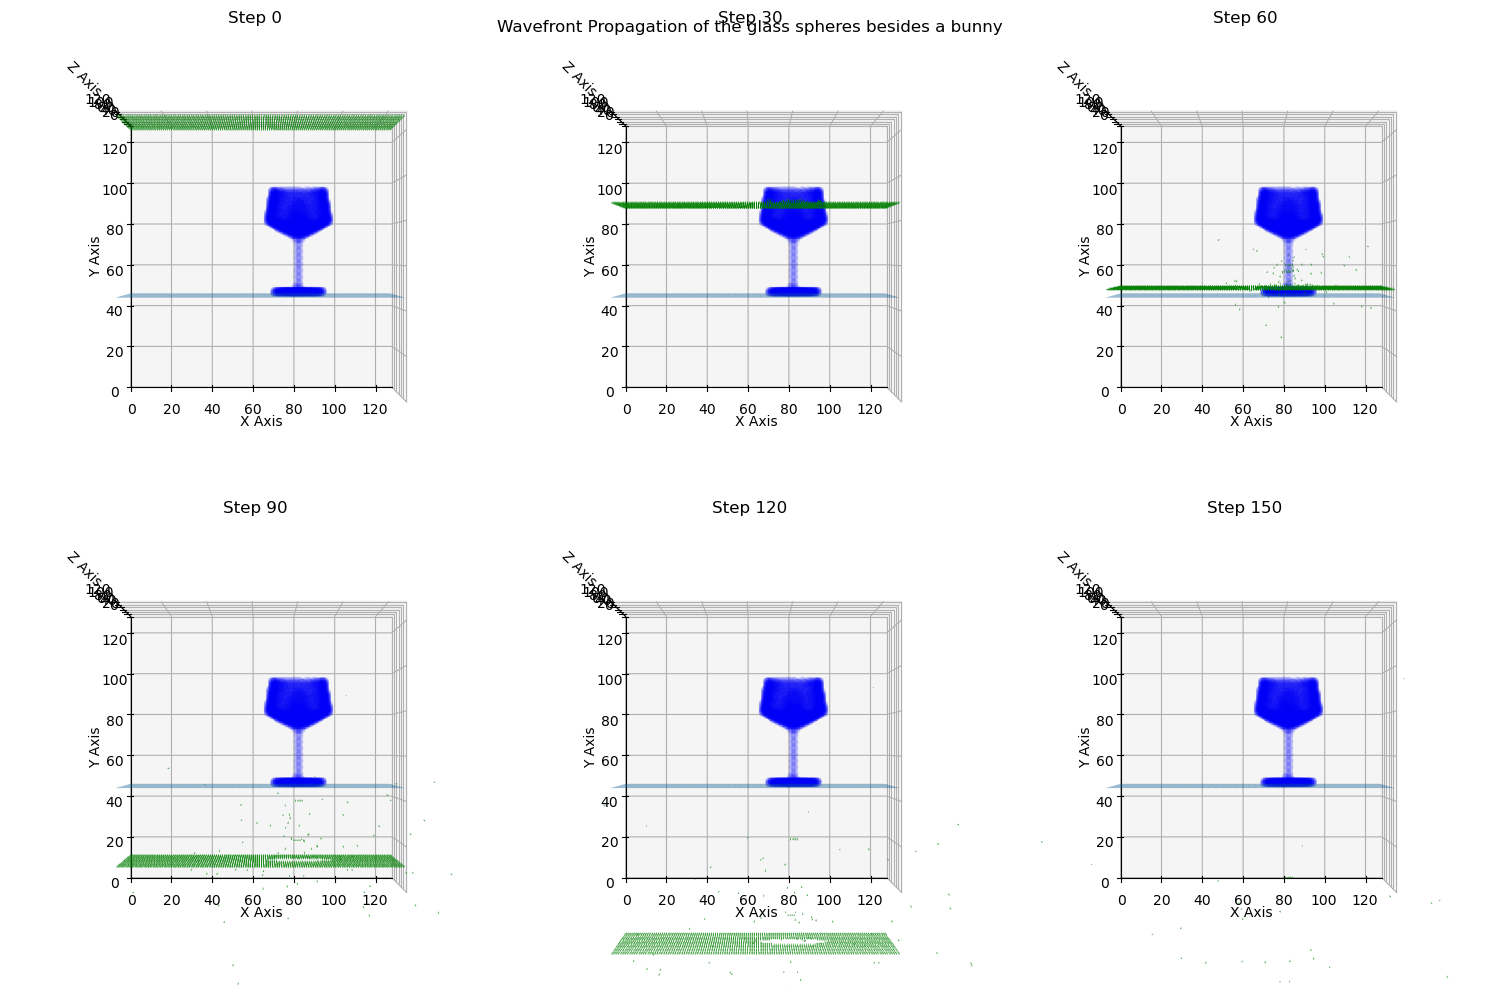

In [28]:
def show_propagation_results(wavefront_pos_list: list[torch.Tensor], wavefront_dir_list: list[torch.Tensor], IOR: torch.Tensor, num_show_images: int, fig_name: str):
    num_cols = min(num_show_images, 3)
    num_rows = (num_show_images + num_cols - 1) // num_cols
    num_steps = len(wavefront_pos_list) - 1  

    show_indices = [i for i in range(0, num_steps+1, max(num_steps // (num_show_images-1), 1))]
    show_indices.append(num_steps)
    if len(show_indices) > num_show_images:
        show_indices = show_indices[:num_show_images]

    fig = plt.figure(figsize=(5 * num_cols, 5 * num_rows))
    
    for i, index in enumerate(show_indices):
        ax = fig.add_subplot(num_rows, num_cols, i + 1, projection='3d')
        ax.set_box_aspect([1,1,1])
        ax.set_xlim(0, IOR.shape[0])
        ax.set_ylim(0, IOR.shape[1])
        ax.set_zlim(0, IOR.shape[2])
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')
        ax.set_title(f"Step {index}")
        
        # Visualize 3D IOR field
        IOR_np = IOR.cpu().numpy()
        x_points, y_points, z_points = np.where(IOR_np == GLASS_IOR)
        subsample_step_sphere = max(1, len(x_points) // 1500)  # Adjust the number to control the number of points
        subsample_indices_sphere = np.arange(0, len(x_points), subsample_step_sphere)
        ax.scatter(x_points[subsample_indices_sphere], y_points[subsample_indices_sphere], z_points[subsample_indices_sphere], color='blue', alpha=0.1)

        # Visualize Wavefront
        wavefront_positions = wavefront_pos_list[index].cpu().numpy()
        wavefront_directions = wavefront_dir_list[index].cpu().numpy()
        subsample_step_wavefront = max(1, wavefront_positions.shape[0] // 2000)  # Adjust the number to control the number of points
        subsample_indices_wavefront = np.arange(0, wavefront_positions.shape[0], subsample_step_wavefront)
        ax.quiver(wavefront_positions[subsample_indices_wavefront, 0], wavefront_positions[subsample_indices_wavefront, 1], wavefront_positions[subsample_indices_wavefront, 2], 
                  wavefront_directions[subsample_indices_wavefront, 0], wavefront_directions[subsample_indices_wavefront, 1], wavefront_directions[subsample_indices_wavefront, 2],
                  length=1, color='green', normalize=True, linewidths=0.7, arrow_length_ratio=0.4, alpha=0.4)
        xx, yy, zz = plot_floor()
        ax.plot_surface(xx, yy, zz, alpha=0.5)
        ax.view_init(elev=90, azim=-90)
        
    fig.tight_layout()
    fig.suptitle(fig_name)
    plt.show()

num_show_images = 6
show_propagation_results(wavefront_positions_list, wavefront_directions_list, scene_ior, num_show_images, "Wavefront Propagation of the glass spheres besides a bunny")

## 5. Compute irradiance

In [29]:
@torch.jit.script
def simple_accumulate_irradiance_into_grid(wavefront_pos_list: list[torch.Tensor], ior_field: torch.Tensor, device: torch.device, remove_below_floor: int | None =None) -> torch.Tensor:
    irradiance_grid = torch.zeros(ior_field.shape, dtype=torch.float32, device=device)
    for pos in wavefront_pos_list:
        indices = pos.int()
        mask = (indices[:, 0] >= 0) & (indices[:, 0] < ior_field.shape[0]) & \
                (indices[:, 1] >= 0) & (indices[:, 1] < ior_field.shape[1]) & \
                (indices[:, 2] >= 0) & (indices[:, 2] < ior_field.shape[2])
        indices = indices[mask]
        unique_indices, counts = torch.unique(indices, return_counts=True, dim=0)
        irradiance_grid[unique_indices[:, 0], unique_indices[:, 1], unique_indices[:, 2]] += counts

    if remove_below_floor is not None:
        irradiance_grid[:, :remove_below_floor, :] = 0

    # normalize
    # irradiance_grid =(irradiance_grid - torch.min(irradiance_grid)) / (torch.max(irradiance_grid) - torch.min(irradiance_grid))
    
    return irradiance_grid

irradiance_grid = simple_accumulate_irradiance_into_grid(wavefront_positions_list, scene_ior, device, int((1+FLOOR_HEIGHT) * NUM_Y / 2))
torch.mean(irradiance_grid), torch.max(irradiance_grid)

(tensor(0.5015, device='cuda:0'), tensor(13., device='cuda:0'))

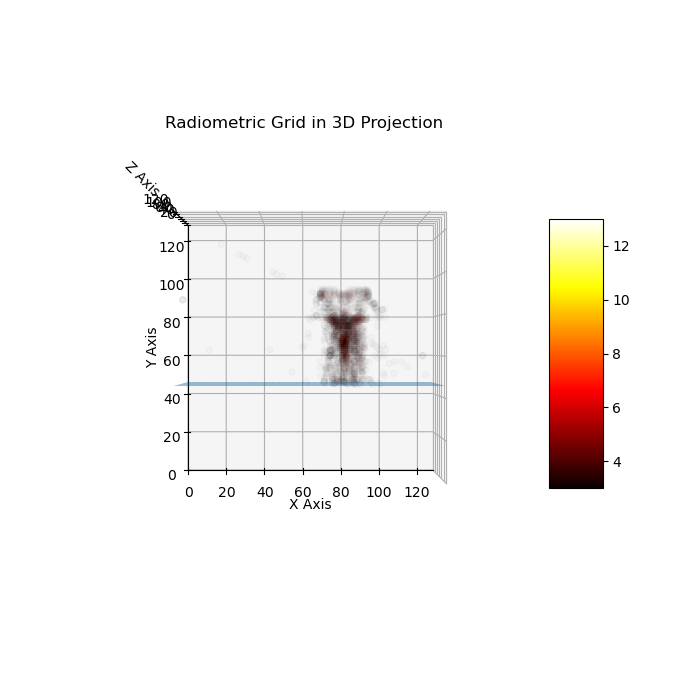

In [30]:
def show_radiometric_grid_3d(radiometric_grid: torch.Tensor, threshold=3.0, only_above_floor=True):
    from matplotlib.colors import Normalize
    from matplotlib.cm import ScalarMappable

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1, 1, 1])
    ax.set_xlim(0, radiometric_grid.size(0))
    ax.set_ylim(0, radiometric_grid.size(1))
    ax.set_zlim(0, radiometric_grid.size(2))
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_title('Radiometric Grid in 3D Projection')
    ax.view_init(elev=90, azim=-90)

    xx, yy, zz = plot_floor()
    ax.plot_surface(xx, yy, zz, alpha=0.5)

    radiometric_grid_np = radiometric_grid.cpu().numpy()
    x_points, y_points, z_points = np.where(radiometric_grid_np > threshold)

    assert len(x_points) > 0, "No points found above the threshold"

    if only_above_floor:
        above_floor_indices = np.where(y_points > -FLOOR_HEIGHT * NUM_Y)
        radiometric_grid_filtered = radiometric_grid_np[x_points[above_floor_indices], y_points[above_floor_indices], z_points[above_floor_indices]]
        x_points = x_points[above_floor_indices]
        y_points = y_points[above_floor_indices]
        z_points = z_points[above_floor_indices]
    else:
        radiometric_grid_filtered = radiometric_grid_np[x_points, y_points, z_points]

    # Create a colormap
    norm = Normalize(vmin=np.min(radiometric_grid_filtered), vmax=np.max(radiometric_grid_filtered))
    mappable = ScalarMappable(norm=norm, cmap='hot')
    mappable.set_array(radiometric_grid_filtered)

    ax.scatter(x_points, y_points, z_points, c=radiometric_grid_filtered, cmap='hot', alpha=0.02)
    fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=5)  # Add colorbar
    plt.show()

show_radiometric_grid_3d(irradiance_grid, threshold=2, only_above_floor=False)

In [30]:
irradiance_grid.shape

torch.Size([128, 128, 128])

## 6. Neural network irradiance （MLP）

In [ ]:
# SEED = 42

# class IrradianceNet(nn.Module):
#     def __init__(self):
#         super(IrradianceNet, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(3, 512),
#             nn.ReLU(),
#             nn.Linear(512, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.Linear(512, 1)
#         )
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.xavier_uniform_(m.weight)

#     def forward(self, x):
#         return self.model(x).squeeze()

# def prepare_data(irradiance: torch.Tensor, train_ratio=0.90) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
#     x = np.arange(irradiance.shape[0])
#     y = np.arange(irradiance.shape[1]) 
#     z = np.arange(irradiance.shape[2])
#     X, Y, Z = np.meshgrid(x, y, z)
#     inputs = np.stack((X, Y, Z), axis=-1).reshape(-1, 3)
#     targets = irradiance.flatten()

#     inputs = torch.from_numpy(inputs).float().to(device)
#     targets = targets.clone().detach().to(device)

#     # Random shuffle
#     # torch.manual_seed(SEED)
#     indices = torch.randperm(len(inputs))
#     inputs = inputs[indices]
#     targets = targets[indices]

#     # Split into training and validation sets
#     train_size = int(train_ratio * len(inputs))
#     train_inputs, val_inputs = inputs[:train_size], inputs[train_size:]
#     train_targets, val_targets = targets[:train_size], targets[train_size:]

#     return train_inputs, val_inputs, train_targets, val_targets

# def train_model(model: IrradianceNet, train_inputs: torch.Tensor, val_inputs: torch.Tensor, train_targets: torch.Tensor, val_targets: torch.Tensor, 
#                 num_epochs=320, batch_size=1024, patience=60):
#     torch.cuda.empty_cache()
    
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

#     best_val_loss = float('inf')
#     epochs_no_improve = 0
#     best_model = None

#     for epoch in range(num_epochs):
#         model.train()
#         for i in range(0, len(train_inputs), batch_size):
#             batch_inputs = train_inputs[i:i+batch_size]
#             batch_targets = train_targets[i:i+batch_size]
            
#             outputs = model(batch_inputs)
#             loss = criterion(outputs, batch_targets)
            
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
        
#         model.eval()
#         with torch.no_grad():
#             val_outputs = model(val_inputs)
#             val_loss = criterion(val_outputs, val_targets)
        
#         if val_loss < best_val_loss * 0.95: # at least 5% improvement
#             best_val_loss = val_loss
#             epochs_no_improve = 0
#             best_model = model.state_dict()
#             print(f"Current best model is at epoch {epoch + 1} and val loss: {val_loss.item():.4f}")
#         else:
#             epochs_no_improve += 1
        
#         if epochs_no_improve == patience:
#             print(f'Early stopping triggered at epoch {epoch + 1}')
#             break
        
#         if (epoch + 1) % 40 == 0:
#             print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

#     assert best_model is not None
#     model.load_state_dict(best_model)
#     torch.cuda.empty_cache()
#     return model

# def generate_irradiance_field_3d(model: IrradianceNet, size=100) -> torch.Tensor:
#     x = np.arange(size)
#     y = np.arange(size)
#     z = np.arange(size)
#     X, Y, Z = np.meshgrid(x, y, z)
#     coords = np.stack((X, Y, Z), axis=-1).reshape(-1, 3)    
#     with torch.no_grad():
#         inputs = torch.tensor(coords, dtype=torch.float32, device=device)
#         predictions = model(inputs)
    
#     return predictions.reshape(size, size, size)

# # Prepare the data and train the MLP model
# train_inputs, val_inputs, train_targets, val_targets = prepare_data(irradiance_grid)
# model = IrradianceNet().to(device)  
# model = train_model(model, train_inputs, val_inputs, train_targets, val_targets)

# # Visualize the predicted irradiance field
# predicted_irradiance = generate_irradiance_field_3d(model)
# show_radiometric_grid_3d(predicted_irradiance, threshold=0.2, only_above_floor=True)

## 7. Octree

Number of nodes: 81
Octree Memory usage: 4536 bytes
In comparison, NumPy Storage Usage: 8388608 bytes


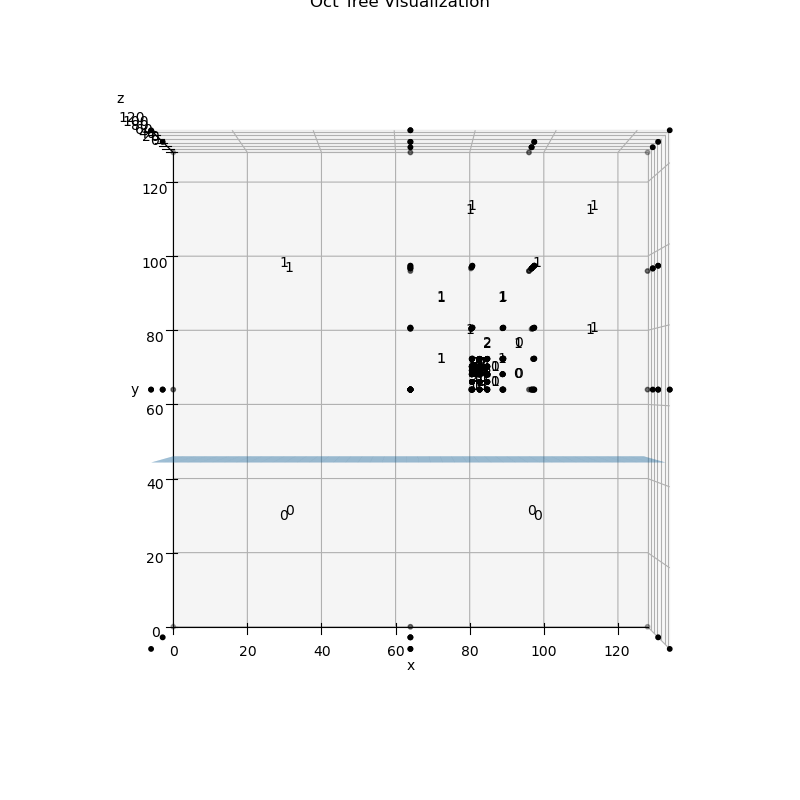

In [31]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import sys

class Node:
    def __init__(self, val: int = 0, children=None):
        self.val = val
        self.children = children or [None] * 8
    
    @property
    def is_leaf(self):
        return all(child is None for child in self.children)
    
    def __repr__(self):
        return self._repr_recursive()

    def _repr_recursive(self, depth=0, max_depth=2):
        indent = "  " * depth
        if self.is_leaf:
            return f"{indent}Node(val={self.val})"
        else:
            if depth >= max_depth:
                return f"{indent}Node(...)"
            children_repr = ",\n".join(self._repr_recursive_child(child, depth + 1, max_depth) for child in self.children)
            return f"{indent}Node(\n{children_repr})"

    def _repr_recursive_child(self, child, depth, max_depth):
        return "  " * depth + "None" if child is None else child._repr_recursive(depth, max_depth)

class OcTree:
    def __init__(self, threshold: int = 0):
        self.threshold = threshold
        self.grid_size = 0
        self.root = None
    
    def construct(self, grid: np.ndarray) -> None:
        self.root = self._build_tree(grid, 0, 0, 0, grid.shape[0])
        self.grid_size = grid.shape[0]
    
    def _build_tree(self, grid: np.ndarray, x: int, y: int, z: int, size: int) -> Node:
        if self._is_homogeneous(grid, x, y, z, size):
            return Node(grid[x, y, z])

        half_size = size // 2
        children = [
            self._build_tree(grid, x, y, z, half_size),
            self._build_tree(grid, x, y, z + half_size, half_size),
            self._build_tree(grid, x, y + half_size, z, half_size),
            self._build_tree(grid, x, y + half_size, z + half_size, half_size),
            self._build_tree(grid, x + half_size, y, z, half_size),
            self._build_tree(grid, x + half_size, y, z + half_size, half_size),
            self._build_tree(grid, x + half_size, y + half_size, z, half_size),
            self._build_tree(grid, x + half_size, y + half_size, z + half_size, half_size)
        ]
        
        if all(child.is_leaf for child in children):
            values = {child.val for child in children}
            if len(values) == 1:
                return Node(values.pop())
        
        return Node(children=children)
    
    def _is_homogeneous(self, grid: np.ndarray, x: int, y: int, z: int, size: int) -> bool:
        return np.ptp(grid[x:x+size, y:y+size, z:z+size]) <= self.threshold

    def query(self, x: int, y: int, z: int) -> int:
        return self._query(self.root, 0, 0, 0, self.grid_size, x, y, z)

    def _query(self, node: Node | None, x: int, y: int, z: int, size: int, qx: int, qy: int, qz: int) -> int:
        if node is None:
            raise ValueError("OcTree is empty. Maybe you forgot to construct it?")
        
        if node.is_leaf:
            return node.val

        half_size = size // 2
        octant = (
            (qx >= x + half_size) << 2 |
            (qy >= y + half_size) << 1 |
            (qz >= z + half_size)
        )
        
        return self._query(
            node.children[octant],
            x + (octant >> 2) * half_size,
            y + ((octant >> 1) & 1) * half_size,
            z + (octant & 1) * half_size,
            half_size,
            qx, qy, qz
        )
    
    def __len__(self):
        return self._count_nodes(self.root)

    def _count_nodes(self, node: Node | None) -> int:
        if node is None:
            return 0
        return 1 + sum(self._count_nodes(child) for child in node.children)
    
    def __sizeof__(self):
        return self._calculate_memory_usage(self.root)
    
    def _calculate_memory_usage(self, node: Node | None) -> int:
        if node is None:
            return 0
        return sys.getsizeof(node) + sum(self._calculate_memory_usage(child) for child in node.children)
    
    def visualize(self, figsize=(8, 8)):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
        self._visualize_node(ax, self.root, 0, 0, 0, self.grid_size)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_xlim(0, self.grid_size)
        ax.set_ylim(0, self.grid_size)
        ax.set_zlim(0, self.grid_size)
        ax.view_init(elev=90, azim=-90)

        xx, yy, zz = plot_floor()
        ax.plot_surface(xx, yy, zz, alpha=0.5)
        plt.tight_layout()
        plt.title('Oct Tree Visualization')
        plt.show()
        
    def _visualize_node(self, ax, node: Node | None, x: float, y: float, z: float, size: float):
        if node is None:
            return
        if node.is_leaf:
            cube = np.array([
                [x, y, z],
                [x + size, y, z],
                [x + size, y + size, z],
                [x, y + size, z],
                [x, y, z + size],
                [x + size, y, z + size],
                [x + size, y + size, z + size],
                [x, y + size, z + size]
            ])
            ax.scatter(cube[:, 0], cube[:, 1], cube[:, 2], c='black', s=10)
            ax.text(x + size / 2, y + size / 2, z + size / 2, str(int(node.val)), ha='center', va='center')
        else:
            half_size = size / 2
            for i, child in enumerate(node.children):
                child_x = x + (i >> 2) * half_size
                child_y = y + ((i >> 1) & 1) * half_size
                child_z = z + (i & 1) * half_size
                self._visualize_node(ax, child, child_x, child_y, child_z, half_size)
    
octree = OcTree(threshold=10)
octree.construct(irradiance_grid.cpu().numpy())
print(f"Number of nodes: {len(octree)}")
print(f"Octree Memory usage: {octree.__sizeof__()} bytes")
print(f"In comparison, NumPy Storage Usage: {irradiance_grid.cpu().numpy().nbytes} bytes")
octree.visualize()

In [32]:
x, y, z = 60, 60, 60
value = octree.query(x, y, z)
value

0.0

## Temp Tests

In [33]:
x = ti.field(float, shape=(3, 3))
a = np.arange(9).reshape(3, 3).astype(np.int32)
x.from_numpy(a)
print(x)
type(x)
arr = x.to_numpy()
print(arr)
type(arr)
field = ti.Vector.field(3, int, shape=(256, 512))
field.shape  # (256, 512)
field.n      # 3

array = field.to_numpy()
array.shape  # (256, 512, 3)
print(type(array))

field.from_numpy(array)  # the input array must in the shape (256, 512, 3)
print(type(field))

[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
<class 'numpy.ndarray'>
<class 'taichi.lang.matrix.MatrixField'>


## *. Render